In [1]:
import re
from collections import defaultdict
import xmltodict
from tqdm import tnrange, tqdm_notebook
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.nn.utils.rnn import pad_sequence

# from pymystem3 import Mystem

In [2]:
torch.manual_seed(1)

In [3]:
device = torch.device("cuda")

In [4]:
def read_input():
    input_filename = "./input.txt"
    lines = []

    with open(input_filename, encoding='utf-8') as input_file:
        for line in input_file:
            lines.append(re.findall(r'\w+', line))

    return lines


In [5]:
def read_X():
    input_filename = "./texts_train.txt"
    lines = []

    with open(input_filename, encoding='utf-8') as input_file:
        for line in input_file:
            lines.append(re.findall(r'\w+', line))

    return lines


In [6]:
def read_Y():
    input_filename = "./scores_train.txt"
    scores = []

    with open(input_filename, encoding='utf-8') as input_file:
        for line in input_file:
            scores.append(int(line) - 1)

    return scores


In [7]:
def read_XY():
    input_filename1 = "./texts_train.txt"
    input_filename2 = "./scores_train.txt"
    dataset = []

    with open(input_filename1, encoding='utf-8') as input_file1:
        with open(input_filename2, encoding='utf-8') as input_file2:
            for line1, line2 in zip(input_file1, input_file2):
                dataset.append((re.findall(r'\w+', line1), int(line2)))

    return np.array(dataset)


In [8]:
X = read_X()
Y = read_Y()

In [9]:
print(X[0])
print(Y[0])

['Сериал', 'очень', 'люблю', 'но', 'Академия', 'и', 'Земля', 'вызывает', 'у', 'меня', 'отторжение', 'идеей', 'Не', 'люблю', 'когда', 'принижают', 'ценность', 'человека', 'как', 'личности', 'даже', 'не', 'смотря', 'на', 'ошибки', 'личности']
5


In [10]:
def build_vocab(dataset, word_to_idx={}):
    for sent in tqdm_notebook(dataset):
        for word in sent:
            if word not in word_to_idx:
                word_to_idx[word.lower()] = len(word_to_idx) + 1

    return word_to_idx

In [11]:
word_to_idx = build_vocab(X)

In [12]:
print(list(word_to_idx.items())[:10])

[('сериал', 109108), ('очень', 108898), ('люблю', 108438), ('но', 109096), ('академия', 45315), ('и', 109024), ('земля', 106349), ('вызывает', 106008), ('у', 108942), ('меня', 108044)]


In [13]:
def my_collate(sent):
    return torch.tensor([word_to_idx[word.lower()] for word in sent])

In [14]:
def pad_dataset(dataset):
    num_dataset = [my_collate(item) for item in dataset]
    return pad_sequence(num_dataset, batch_first=True, padding_value=0)

In [15]:
X_padded = pad_dataset(X)

In [16]:
print(X_padded[0])

tensor([109108, 108898, 108438,  ...,      0,      0,      0])


In [17]:
def join_dataset(X, Y):
    dataset = torch.zeros(X.shape[0], X.shape[1] + 1)
    dataset[:, :X.shape[1]] = X
    dataset[:, X.shape[1]] = torch.tensor(Y)
    return dataset

In [18]:
dataset = join_dataset(X_padded, Y)

In [19]:
print(dataset.shape)

torch.Size([20000, 3181])


In [20]:
train, val = train_test_split(dataset.numpy(), test_size=0.2, random_state=42)

In [51]:
class MySentiment(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_layers, bidirectional, vocab_size, tagset_size):
        super(MySentiment, self).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, bidirectional=bidirectional, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, tagset_size)
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, batch):
        embeds = self.word_embeddings(batch)
        lstm_out, _ = self.lstm(embeds)
        tag_space = self.fc2(self.fc1(self.dropout(lstm_out)))
#         tag_space_sum = tag_space.sum(dim=1)
        tag_space_sum = tag_space[:, -1]
        tag_scores = F.softmax(tag_space_sum)
        return tag_scores

In [52]:
def fit(model, train, val, optimizer, loss_function, epoch_cnt, batch_size):
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val, batch_size=batch_size)
    train_loss_values = []
    val_loss_values = []
            
    for epoch in tnrange(epoch_cnt, desc='Epoch'):
        for batch_data in tqdm_notebook(train_loader, desc='Train'):
            x, y = batch_data[:, :-1].to(device), batch_data[:, -1].to(device)
            optimizer.zero_grad()
            output = model(x.long())
            loss = loss_function(output, y.long())
            train_loss_values.append(loss)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 5)
            optimizer.step()

        with torch.no_grad():
            loss_values = []
            for batch_data in tqdm_notebook(val_loader, desc='Validate'):
                x, y = batch_data[:, :-1].to(device), batch_data[:, -1].to(device)
                output = model(x.long())
                loss = loss_function(output, y.long())
                loss_values.append(loss.item())
            val_loss_values.append(np.mean(np.array(loss_values)))

    return train_loss_values, val_loss_values 


In [53]:
embedding_dim = 32
hidden_dim = 32
num_layers = 1
bidirectional = False
vocab_size = len(word_to_idx) + 1
tagset_size = 10

In [55]:
model = MySentiment(embedding_dim, hidden_dim, num_layers, bidirectional, vocab_size, tagset_size)
model = model.float()
model = model.to(device)

In [56]:
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [58]:
torch.cuda.empty_cache()

In [59]:
epoch_cnt = 5
batch_size = 512
train_loss_values, val_loss_values =\
    fit(model, train, val, optimizer, loss_function, epoch_cnt, batch_size)

C:\Users\Vadim\anaconda3\envs\ML\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [60]:
def plot_loss_values(train_loss_values, val_loss_values):
    plt.plot(np.arange(len(train_loss_values)), train_loss_values, color='blue', label='train')
    plt.plot(np.arange(0, len(train_loss_values), len(train_loss_values) / epoch_cnt), val_loss_values, color='red', label='validation')
    plt.legend()
    plt.title("Loss values")
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()

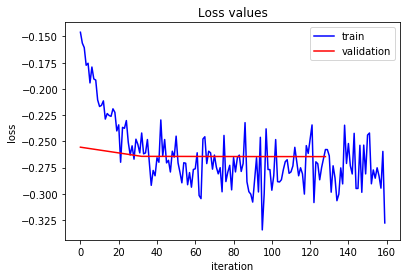

In [61]:
plot_loss_values(train_loss_values, val_loss_values)

In [47]:
test = read_input()
word_to_idx_ext = build_vocab(test, word_to_idx)
test_padded = pad_dataset(test)

In [62]:
with torch.no_grad():
    test_loader = torch.utils.data.DataLoader(test_padded, batch_size=batch_size)
    ans = np.array([], dtype=int)
    
    for batch_data in tqdm_notebook(test_loader, desc='Test'):
        x = batch_data.to(device)
        output = model(x.long())
        _, ansx = output.max(dim=1)
        ansx = ansx.cpu().numpy() + 1
        ans = np.append(ans, ansx)

C:\Users\Vadim\anaconda3\envs\ML\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [65]:
output_filename = "./output.txt"
with open(output_filename, "w", encoding="utf-8") as output_file:
    for tag in ans:
        output_file.write(str(tag))
        output_file.write("\n")

In [112]:
torch.save(model.state_dict(), "./models/lstm_64_128_1_True_SGD_1e-2_25e_w.pt")
torch.save(model, "./models/lstm_64_128_1_True_SGD_1e-2_25e_f.pt")